In [3]:
from typing import NoReturn, TypeAlias, List, Tuple, Dict, Any

import polars as pl
import numpy as np

ModuleNotFoundError: No module named 'polars'

In [55]:
PRNG: TypeAlias = np.random._generator.Generator

Dataframe_Data: TypeAlias = Dict[str, Any]

Normal_Dataframe: TypeAlias = pl.dataframe.frame.DataFrame
Lazy_Dataframe: TypeAlias = pl.lazyframe.frame.LazyFrame
Dataframe: TypeAlias = Normal_Dataframe | Lazy_Dataframe

Dataframe_Display: TypeAlias = str | NoReturn | Dataframe

Type: TypeAlias = str
Schema_Typed: TypeAlias = Dict[str, Type]

Columns: TypeAlias = Tuple[str]
Context_Operations: TypeAlias = str

# Data_Typed: TypeAlias = Tuple[Type, Any]
# Dataframe_Class_Init: TypeAlias = Dict[str, Data_Typed]

In [7]:
type(np.random.default_rng(seed=7))

numpy.random._generator.Generator

In [13]:
type(pl.DataFrame())

polars.dataframe.frame.DataFrame

In [70]:
type(pl.LazyFrame(buildings))

polars.lazyframe.frame.LazyFrame

In [75]:
type(lazy_buildings)

polars.lazyframe.frame.LazyFrame

In [76]:
type(lazy_query)

polars.lazyframe.frame.LazyFrame

# Notes
## Polars
- The core DS used in Polars is the DataFrame
    - A DataFrame is a two-dimensional data structure composed of rows and columns.
    - The columns of a DataFrame are made up of series, which are one-dimensional labeled arrays.
- Contexts and expressions are core components of Polars' data transformation syntax
    - Expressions are computations/transformations performed on data columns
    - A context is the environment which an expression is evaluated.
        1. Selection: over columns
        2. Filtering: extracts rows
        3. Groupby/aggregation: computing over subgroups of the data
        - Gist: selection grabs columns, filtering pares down the rows, and groupby/aggregation deals with the expression syntax over what's left 
    - Contexts are verbs and expressions are nouns. Or... expressions are the what when applying transformations, and the contexts are the how when preparing the environment/data, as well as, how the expressions will be executed. Remember that Polars is concurrent by design, contexts help broker how that works in the background.
- All Polars expressions are optimized and run in parallel under the hood
- Polars’ lazy API is one of the most powerful features of the library. With the lazy API, you can specify a sequence of operations without immediately running them. Instead, these operations are saved as a computational graph and only run when necessary. This allows Polars to optimize queries before execution, catch schema errors before the data is processed, and perform memory-efficient queries on datasets that don’t fit into memory.
- LazyFrame
    - Before you execute the query, you can inspect the query plan using the show_graph() method
        - Does predicate pushdown, a Polars optimization that applies filters as early as possible
        - The query plan cuts out things, to see the full diagram use the explain() method
    - To execute a query you need to call the collect method
- Polars can connect directly to a database and execute SQL queries.

## Numpy
- To generate random numbers, you call default_rng() from NumPy’s random module. This returns a generator that can produce a variety of random numbers according to different probability distributions.
    - Since version 1.17, NumPy uses the permuted congruential generator-64 (PCG64) algorithm to generate random numbers.
    - PCG64 is more efficient and produces less predictable numbers

In [10]:
def set_random(seed: int) -> PRNG:
    return np.random.default_rng(seed=seed)

In [82]:
numpy_data = np.array([
    [1, 2, 3, 4, 5],
    [6, 7, 8, 9, 10]
]).T

pl.from_numpy(numpy_data, schema={"A": pl.Int64, "B": pl.Int64})

A,B
i64,i64
1,6
2,7
3,8
4,9
5,10


## Normal Dataframe Handling

In [50]:
def scrap_type(data: Any) -> Data_Typed:
    return str(type(data)).split("'")[1], data

In [51]:
scrap_type(1)

('int', 1)

In [60]:
def generate_df(data: Dataframe_Data, lazy: bool = False) -> Dataframe:
    if lazy:
        return pl.LazyFrame(data)
    return pl.DataFrame(data)

In [61]:
def df_display(df: Dataframe, option: str = 'schema') -> Dataframe_Display:
    match option:
        case 'schema':
            return df.schema
        case 'head':
            return df.head()
        case 'describe':
            return df.describe()
        case _:
            raise Exception(f'{ option } is\'nt supported!')

In [69]:
num_rows = 5000
rng = set_random(7)

buildings_data = {
    "sqft": rng.exponential(scale=1000, size=num_rows),
    "price": rng.exponential(scale=100_000, size=num_rows),
    "year": rng.integers(low=1995, high=2023, size=num_rows),
    "building_type": rng.choice(["A", "B", "C"], size=num_rows)
}

In [37]:
for idx, option in enumerate(('schema', 'head', 'describe')):
    print(f'Displaying the { option } option\n{ df_display(buildings, option=option) }')
    
    if idx != 2:
        print('\n')

Displaying the schema option
OrderedDict([('sqft', Float64), ('year', Int64), ('building_type', String)])


Displaying the head option
shape: (5, 3)
┌─────────────┬──────┬───────────────┐
│ sqft        ┆ year ┆ building_type │
│ ---         ┆ ---  ┆ ---           │
│ f64         ┆ i64  ┆ str           │
╞═════════════╪══════╪═══════════════╡
│ 707.529256  ┆ 1996 ┆ C             │
│ 1025.203348 ┆ 2020 ┆ C             │
│ 568.548657  ┆ 2012 ┆ A             │
│ 895.109864  ┆ 2000 ┆ A             │
│ 206.532754  ┆ 2011 ┆ A             │
└─────────────┴──────┴───────────────┘


Displaying the describe option
shape: (9, 4)
┌────────────┬─────────────┬───────────┬───────────────┐
│ statistic  ┆ sqft        ┆ year      ┆ building_type │
│ ---        ┆ ---         ┆ ---       ┆ ---           │
│ str        ┆ f64         ┆ f64       ┆ str           │
╞════════════╪═════════════╪═══════════╪═══════════════╡
│ count      ┆ 5000.0      ┆ 5000.0    ┆ 5000          │
│ null_count ┆ 0.0         ┆ 0.0 

In [71]:
buildings = generate_df(buildings_data)

In [40]:
buildings.select(pl.col("sqft").sort() / 1000)

sqft
f64
0.001133
0.001152
0.001429
0.001439
0.001505
…
6.931917
7.247539
7.629569


In [41]:
after_2015 = buildings.filter(pl.col("year") > 2015)
after_2015.shape

(1230, 3)

In [42]:
after_2015.select(pl.col("year").min())

year
i64
2016


In [44]:
buildings.group_by("building_type").agg(
    [
        pl.mean("sqft").alias("mean_sqft"),
        pl.median("year").alias("median_year"),
        pl.len(),
    ]
)

building_type,mean_sqft,median_year,len
str,f64,f64,u32
"""B""",992.754444,2009.0,1655
"""C""",999.854722,2009.0,1692
"""A""",989.539918,2009.0,1653


In [83]:
buildings.to_numpy()

array([[707.5292557919215, 86928.59338505926, 2011, 'A'],
       [1025.203348294905, 40787.436652471086, 2016, 'C'],
       [568.5486573832515, 145524.59522088937, 2010, 'C'],
       ...,
       [57.562058564789915, 44406.81451850381, 2017, 'A'],
       [3728.0889487033314, 44521.146461668344, 1999, 'A'],
       [686.6783449693073, 73591.32196098166, 1995, 'B']], dtype=object)

## Lazy Dataframe Handling
### Queries

In [72]:
lazy_buildings = generate_df(buildings_data, lazy=True)

polars.lazyframe.frame.LazyFrame

In [73]:
lazy_query = (
    lazy_buildings
        .with_columns(
            (pl.col("price") / pl.col("sqft")).alias("price_per_sqft")
        )
        .filter(pl.col("price_per_sqft") > 100)
        .filter(pl.col("year") < 2010)
)

polars.lazyframe.frame.LazyFrame

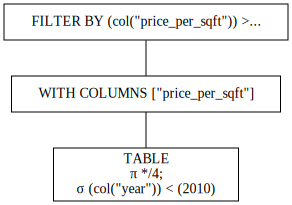

In [78]:
lazy_query.show_graph()

- Sigma (σ) and pi (π) are symbols from relational algebra, and they tell you the operation that you’re performing on the data.
- In this example, π */4 says that you’re working with all four columns of the DataFrame, and σ(col(“year”)) < 2010 tells you that you’re only processing rows with a year less than 2010. You can interpret the full query plan with these steps:
    1. Use the four columns of buildings_lazy, and filter buildings_lazy to rows where year is less than 2010.
    2. Create the price_per_sqft column.
    3. Filter buildings_lazy to all rows where price_per_sqft is greater than 100.

In [81]:
(
    lazy_query
        .collect()
        .select(pl.col(['price_per_sqft', 'year']))
        .head()
)

price_per_sqft,year
f64,i64
3268.19045,1996
274.339166,2000
296.979717,2004
378.86472,2002
127.302589,1995


### Scanning Data
- When you scan a file, rather than reading the entire file into memory, Polars creates a LazyFrame that references the file’s data. As before, no processing of the data occurs until you explicitly execute a query.
    - The only thing that's stored right away is the schema
    - Polars must know the schema before executing any step of a query plan.
    - No computation is performed until you call lazy_car_query.collect(). After the query is executed, only the data you asked for is stored and returned—nothing more.

In [46]:
str(type(1))

"<class 'int'>"

In [ ]:
'''
    # data.json
    {
        'A': 1,
        'B': 2
    }
'''

data_json_lazy = pl.scan_ndjson("data.json")
data_json_lazy.schema

### Lazy Application

In [ ]:
class Polars_Abstraction:
    # The Schema_Typed is important for validating queries before their executed. Takes advantage of Polars.
    def __init__(self, df_name: str, data: Dataframe_Data):
        self.df_name: str = df_name
        self.df: Lazy_Dataframe = generate_df(data, lazy=True)
        
        self.schema: Schema_Typed = {key: scrap_type(value) for key, value in data.items()}
        
    # HERE tonight... Polish notation problem using ordered operations
    def get(self, columns: Columns = None, operations: Context_Operations = None) -> Dataframe_Display:
        # Build context here!
        
        '''
            match option:
                case 'dataframe':
                    return self.df
                case 'select':
                    return self.df.select(context)
                case 'context_select':
                    pass
                case _:
                    pass
        '''
        pass
            
    def display(self, option: str = 'schema_typed') -> Dataframe_Display:
        match option:
            case 'dataframe':
                return self.df
            case 'schema_typed':
                return self.schema
            case 'schema':
                return self.df.schema
            case 'head':
                return self.df.head()
            case 'describe':
                return self.df.describe()
            case 'query_plan':
                # This one appears to immediately send the results to Matplotlib in the background
                self.df.show_graph()
            case _:
                raise Exception(f'{ option } is\'nt supported!')

### Using Datetime

In [2]:
from datetime import datetime

df = pl.DataFrame(
    {
        "integer": [1, 2, 3],
        "date": [
            datetime(2025, 1, 1),
            datetime(2025, 1, 2),
            datetime(2025, 1, 3),
        ],
        "float": [4.0, 5.0, 6.0],
        "string": ["a", "b", "c"],
    }
)

print(df)

shape: (3, 4)
┌─────────┬─────────────────────┬───────┬────────┐
│ integer ┆ date                ┆ float ┆ string │
│ ---     ┆ ---                 ┆ ---   ┆ ---    │
│ i64     ┆ datetime[μs]        ┆ f64   ┆ str    │
╞═════════╪═════════════════════╪═══════╪════════╡
│ 1       ┆ 2025-01-01 00:00:00 ┆ 4.0   ┆ a      │
│ 2       ┆ 2025-01-02 00:00:00 ┆ 5.0   ┆ b      │
│ 3       ┆ 2025-01-03 00:00:00 ┆ 6.0   ┆ c      │
└─────────┴─────────────────────┴───────┴────────┘


In [5]:
df.filter(
    pl.col("date").is_between(datetime(2025, 1, 2), datetime(2025, 1, 3)),
)

integer,date,float,string
i64,datetime[μs],f64,str
2,2025-01-02 00:00:00,5.0,"""b"""
3,2025-01-03 00:00:00,6.0,"""c"""


### Streaming API
#### Still in development
- execute the query in batches allowing you to process datasets that are larger-than-memory
- However, not all lazy operations support streaming
- Ones supported as of Feb 29, 2024
    - filter, slice, head, tail, with_columns, select, group_by, join, unique, sort, explode, melt